# FEM7LB02

БГУ, ММФ  
4 курс, 5 группа  
Мухин Владислав

https://fenicsproject.org/docs/dolfin/1.4.0/python/demo/documented/subdomains-poisson/python/documentation.html

https://fenicsproject.org/pub/tutorial/sphinx1/._ftut1005.html#combining-dirichlet-and-neumann-conditions

Stable mshr conda version:  
conda install -y -c conda-forge mshr=2019.1.0=py38h255090a_2

## Task Description

## Equation and Problem Definition

We consider a weighted Poisson equation over $\Omega = \Omega_1 \cup \Omega_2 = (0, 0.5) \times (-\delta, \delta) \cup (0.5, 1) \times (-\delta, \delta)$ with mixed boundary conditions: find $u$ satisfying

\begin{equation*}
\left\{
\begin{array}{ll}
-\nabla k \nabla u = 0 & \text{in}~\Omega \\
u = 0 & \text{on}~\Gamma_{L}, \\
u = T_0 & \text{on}~\Gamma_{R}, \\
-k \dfrac{\partial u}{\partial n} = 0 & \text{on}~\Gamma_{T} \cup \Gamma_{B}.
\end{array}
\right.
\end{equation*}
where $\Gamma_{L}, \Gamma_{R}, \Gamma_{T}, \Gamma_{B}$ denote the left, right, top and bottom sides, respectively. The coefficient $k$ may vary over the domain: here, we let $k = k_1$ in $\Omega_{1}$ and $k = k_2$ in $\Omega_{2}$.

## Variational Form

Find $u \in V$ such that:

$$a(u, v) = L(v), \quad \forall v \in \hat{V}$$

$$ a(u, v) = \int_{\Omega_1} k_1 \nabla u \cdot \nabla v~dx + \int_{\Omega_2} k_2 \nabla u \cdot \nabla v~dx, $$
$$ L(v) =  \int_{\Omega} f~v~dx - \int_{\Gamma_T} g_{T}~v~ds - \int_{\Gamma_B} g_{B}~v~ds $$
where $f = 0, g_{L} = 0, g_{R} = T_0$.

## Imports

In [2]:
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

--2021-10-06 17:04:22--  https://fem-on-colab.github.io/releases/fenics-install.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1946 (1.9K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   1.90K  --.-KB/s    in 0s      

2021-10-06 17:04:22 (10.5 MB/s) - ‘/tmp/fenics-install.sh’ saved [1946/1946]

+ PYBIND11_INSTALL_SCRIPT_PATH=https://fem-on-colab.github.io/releases/pybind11-install.sh
+ [[ https://fem-on-colab.github.io/releases/pybind11-install.sh == http* ]]
+ wget https://fem-on-colab.github.io/releases/pybind11-install.sh -O /tmp/pybind11-install.sh
--2021-10-06 17:04:22--  https://fem-on-colab.github.io/releases/pybind11-install.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.1

In [4]:
import dolfin as dlf
import fenics as fnx
import mshr as mr
import numpy as np
import sympy as sp
import ufl
from matplotlib import pyplot as plt

## Solution

### Initial Data

In [5]:
k = [1, 10]
T0 = 10.0
δ = 1.0

f = dlf.Constant(0)

u_left = dlf.Constant(0)
u_right = dlf.Constant(T0)

g_top = dlf.Constant(0)
g_bottom = dlf.Constant(0)

### Defining Mesh and Subdomains

In [6]:
resolution = 16
Ω = mr.Rectangle(dlf.Point(0, -δ), dlf.Point(1, δ))
Ω.set_subdomain(1, mr.Rectangle(dlf.Point(1 / 2, -δ), dlf.Point(1, δ)))
mesh = mr.generate_mesh(Ω, resolution)

In [7]:
V = dlf.FunctionSpace(mesh, "P", 1)

u = dlf.TrialFunction(V)
v = dlf.TestFunction(V)

Calling FFC just-in-time (JIT) compiler, this may take some time.


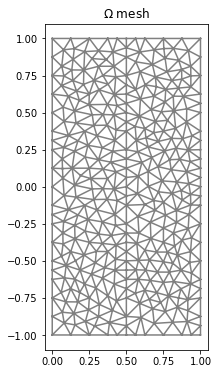

In [8]:
fig, ax = plt.subplots(figsize=(6, 6))

dlf.plot(mesh)

ax.set_title("$\Omega$ mesh")
ax.set_aspect(1)

plt.show()

In [9]:
_TOLERANCE = 1e-14


class Ω0(dlf.SubDomain):
    def inside(self, x, on_boundary):
        return x[0] <= 0.5 + _TOLERANCE


class Ω1(dlf.SubDomain):
    def inside(self, x, on_boundary):
        return 0.5 - _TOLERANCE <= x[0]

In [10]:
# https://scicomp.stackexchange.com/questions/32647/how-to-use-meshfunction-in-fenics-dolfin
# possible types for CellFunction:
#     size_t (unsigned int)
#     int
#     double
#     bool
materials = dlf.MeshFunction(
    "size_t", mesh, mesh.topology().dim(), mesh.domains()
)  # dim = 2 -- cell level

# subdomains = [Ω0(), Ω1()]

# for i, Ωi in enumerate(subdomains):
#     Ωi.mark(materials, i)

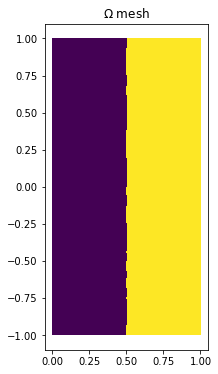

In [11]:
fig, ax = plt.subplots(figsize=(6, 6))

dlf.plot(materials)

ax.set_title("$\Omega$ mesh")
ax.set_aspect(1)

plt.show()

### Modeling Thermal Conductivity Coefficient (κ)

In [12]:
class K(dlf.UserExpression):
    def __init__(self, materials, k):
        element = ufl.FiniteElement(family="Real", cell=None, degree=0)
        super().__init__(self, element=element)
        self.materials = materials
        self.k = k

    def eval_cell(self, values, x, cell):
        values[0] = self.k[self.materials[cell.index]]


κ = K(materials, k)

In [13]:
# κ = dlf.Expression(
#     "x[0] <= 0.5 + tol ? k0 : k1",
#     degree=0,
#     tol=_TOLERANCE,
#     k0=k[0],
#     k1=k[1],
# )

### Variational Problem and Boundary Conditions

In [14]:
class Γ_L(dlf.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and dlf.near(x[0], 0, _TOLERANCE)


class Γ_R(dlf.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and dlf.near(x[0], 1, _TOLERANCE)


class Γ_B(dlf.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and dlf.near(x[1], -δ, _TOLERANCE)


class Γ_T(dlf.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and dlf.near(x[1], δ, _TOLERANCE)


boundary_markers = dlf.MeshFunction("size_t", mesh, mesh.topology().dim() - 1)

boundaries = [Γ_L, Γ_R, Γ_B, Γ_T]

for i, b in enumerate(boundaries):
    b().mark(boundary_markers, i + 1)

In [15]:
dbc_left = dlf.DirichletBC(V, u_left, boundary_markers, 1)
dbc_right = dlf.DirichletBC(V, u_right, boundary_markers, 2)

dbcs = [dbc_left, dbc_right]

In [16]:
dx = dlf.Measure("dx", domain=mesh, subdomain_data=materials)
ds = dlf.Measure("ds", domain=mesh, subdomain_data=boundary_markers)

![image.png](attachment:8dd955bc-8915-4319-93de-9e721db5cd8d.png)

In [17]:
a = κ * dlf.dot(dlf.grad(u), dlf.grad(v)) * dx
L = f * v * dx - (g_bottom * v * ds(3) + g_top * v * ds(4))

In [18]:
uu = dlf.Function(V)
dlf.solve(a == L, uu, dbcs)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


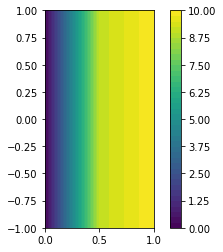

In [19]:
p = dlf.plot(uu)
plt.colorbar(p)

plt.show()

### Exact Solution

In [20]:
x = sp.symbols("x[0]")
# k1, k2 = sp.symbols("k1, k2")
k1, k2 = k
a, b, c, d = sp.symbols("a, b, c, d")


def t1(x):
    return a * x + b


def t2(x):
    return c * x + d

In [21]:
equations = [
    sp.Eq(t1(0), 0),
    sp.Eq(t2(1), T0),
    sp.Eq(t1(1 / 2) - t2(1 / 2), 0),
    sp.Eq(k1 * t1(x).diff(x).subs({x: 1 / 2}) - k2 * t2(x).diff(x).subs({x: 1 / 2}), 0),
]

In [22]:
coeffs = sp.solve(equations, a, b, c, d)
coeffs

{a: 18.1818181818182, b: 0.0, c: 1.81818181818182, d: 8.18181818181818}

In [23]:
t = (
    f"({t1(x).subs(coeffs)}) * (1 - (x[0] < 0.5 ? 0.0 : (0.5 < x[0] ? 1.0 : 0.5))) "
    f"+ ({t2(x).subs(coeffs)}) * (x[0] < 0.5 ? 0.0 : (0.5 < x[0] ? 1.0 : 0.5))"
)
u_e = dlf.Expression(t, degree=1)

### Comparing Exact and Approximate Solutions

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


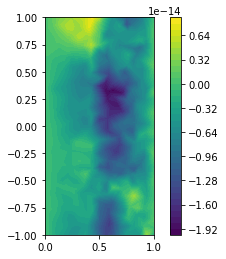

In [24]:
p = dlf.plot(u_e - uu)
plt.colorbar(p)

plt.show()

In [25]:
dlf.errornorm(u_e, uu, "L2")

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


1.0111426925406603e-14

In [26]:
vertex_values_u_e = u_e.compute_vertex_values(mesh)
vertex_values_uu = uu.compute_vertex_values(mesh)

In [27]:
error_max = np.max(np.abs(vertex_values_u_e - vertex_values_uu))
error_max

1.9539925233402755e-14

## Debugging

In [ ]:
# if V.ufl_element().degree() == 1:  # P1 elements
#     d2v = dlf.dof_to_vertex_map(V)
#     coor = mesh.coordinates()
#     for i, bc in enumerate(dbcs):
#         print("Dirichlet condition %d" % i)
#         boundary_values = bc.get_boundary_values()
#         for dof in boundary_values:
#             print("dof %2d: u = %g" % (dof, boundary_values[dof]))
#             if V.ufl_element().degree() == 1:
#                 print("at point %s" % (str(tuple(coor[d2v[dof]].tolist()))))

In [ ]:
%load_ext watermark

In [ ]:
%watermark -a vlad.muhin1999@mail.ru -u -d -v -iv -w

Author: vlad.muhin1999@mail.ru

Last updated: 2020-12-18

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.19.0

numpy     : 1.19.4
ufl       : 2019.1.0
sympy     : 1.7.1
matplotlib: 3.3.3
dolfin    : 2019.1.0
mshr      : 2019.1.0

Watermark: 2.1.0

